# $\color{magenta}{\text{Spiral Elliptical Classifier}}$

### $\color{yellow}{\text{Modules First!}}$





In [ ]:
import torch

#### **Installing the Required Modules**

In [1]:
!pip install -Uqq fastbook
!pip install astropy

     |████████████████████████████████| 727kB 22.1MB/s 
     |████████████████████████████████| 1.2MB 46.9MB/s 
     |████████████████████████████████| 51kB 8.8MB/s 
     |████████████████████████████████| 194kB 61.6MB/s 
     |████████████████████████████████| 61kB 10.0MB/s 


#### **Importing the Required Modules**

In [2]:
from fastbook import *
from astropy.io import fits
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import os
import time

### $\color{yellow}{\text{Getting the Data}}$

#### **Extracting Coordinates from the Catalogue Dataset**

In [24]:
Galaxies_dat_hud=fits.open('drive/MyDrive/Spiral_Elliptical_Classifier/Spiral_Elliptical_Catalogue.fits')

In [25]:
Galaxies_dat=Galaxies_dat_hud[1].data

In [26]:
Spiral_ones=Galaxies_dat['SPIRAL']
Elliptical_ones=Galaxies_dat['ELLIPTICAL']
Uncertain_ones=Galaxies_dat['UNCERTAIN']

In [27]:
Spiral_dat=Galaxies_dat[Spiral_ones==1]
Elliptical_dat=Galaxies_dat[Elliptical_ones==1]
Uncertain_dat=Galaxies_dat[Uncertain_ones==1]

In [28]:
Spiral_ras = Spiral_dat['RA']
Spiral_decs = Spiral_dat['DEC']
Elliptical_ras = Elliptical_dat['RA']
Elliptical_decs = Elliptical_dat['DEC']
Uncertain_ras = Uncertain_dat['RA']
Uncertain_decs = Uncertain_dat['DEC']

In [ ]:
Spiral_ras[0], Spiral_decs[0]

('00:00:00.74', '-09:13:20.2')

#### **Getting URLs from the Coordinates**

In [29]:
def get_image_urls(ras, decs, width, height):
    urls=[]
    for ra,dec in zip(ras,decs):
        urls.append(f'http://skyserver.sdss.org/dr16/SkyServerWS/ImgCutout/getjpeg?ra={ra}&dec={dec}&width={width}&height={height}&scale=0.1&.jpg')
    return urls

In [30]:
Spurls=get_image_urls(ras=Spiral_ras, decs=Spiral_decs, width=512, height=512)
Ellurls=get_image_urls(ras=Elliptical_ras, decs=Elliptical_decs, width=512, height=512)
Unurls=get_image_urls(ras=Uncertain_ras, decs=Uncertain_decs, width=512, height=512)
len(Spurls), len(Ellurls), len(Unurls)

(190225, 62190, 415529)

#### **Creating Folders to store the Image Data**

In [ ]:
#Only at the start
#Already done
os.mkdir('drive/MyDrive/Spiral_Elliptical_Classifier/Data_20')
os.mkdir('drive/MyDrive/Spiral_Elliptical_Classifier/Data_20/Spiral')
os.mkdir('drive/MyDrive/Spiral_Elliptical_Classifier/Data_20/Elliptical')
os.mkdir('drive/MyDrive/Spiral_Elliptical_Classifier/Data_20/Uncertain')

#### **Downloading the Image data from the URLs**

In [ ]:
#Already done
time1=time.perf_counter()
download_images('drive/MyDrive/Spiral_Elliptical_Classifier/Data_20/Elliptical',urls=Ellurls[0:20000])
download_images('drive/MyDrive/Spiral_Elliptical_Classifier/Data_20/Spiral',urls=Spurls[0:20000])
download_images('drive/MyDrive/Spiral_Elliptical_Classifier/Data_20/Uncertain',urls=Unurls[0:20000])
time2=time.perf_counter()
print(time2-time1)

4010.6150588420005


In [ ]:
download_images('',urls=Ellurls[0:2])

### $\color{yellow}{\text{Classifier in Making}}$

#### **Creating Dataloaders**

In [6]:
datblk = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=TrainTestSplitter(test_size=0.2, random_state=42, shuffle=True),
    get_y=parent_label,
    item_tfms=Resize(512),
    batch_tfms=aug_transforms())

In [7]:
datlds=datblk.dataloaders('drive/MyDrive/Spiral_Elliptical_Classifier/Data')

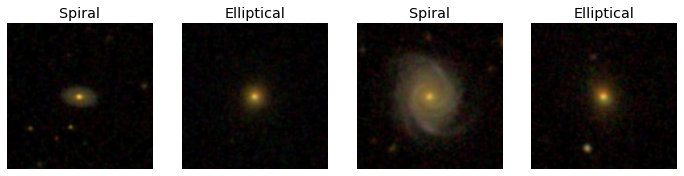

In [8]:
datlds.valid.show_batch(max_n=4, nrows=1)

#### **Learning in Progress**

In [13]:
Spiral_Elliptical_Classifier = cnn_learner(datlds, resnet34, metrics=accuracy)

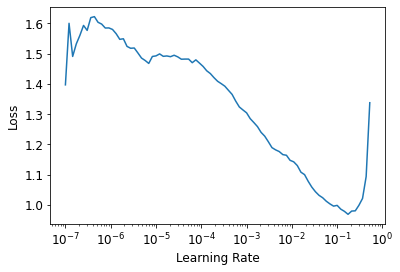

In [ ]:
lr=Spiral_Elliptical_Classifier.lr_find()

In [ ]:
Spiral_Elliptical_Classifier.recorder.train_metrics=True

In [21]:
Spiral_Elliptical_Classifier.fine_tune(5, lr[0], cbs=EarlyStoppingCallback(patience=7))

epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time
0,0.027362,0.991146,0.258642,0.958750,04:46


epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time
0,0.033501,0.990417,0.177845,0.954583,06:43
1,0.042172,0.985729,0.378429,0.890417,06:44
2,0.049181,0.984479,0.102731,0.967500,06:44
3,0.026057,0.991979,0.083290,0.980833,06:44
4,0.012765,0.995417,0.087982,0.980000,06:43


In [ ]:
torch.cuda.empty_cache()

#### **Interpretation**

In [ ]:
interp = ClassificationInterpretation.from_learner(Spiral_Elliptical_Classifier)
interp.plot_confusion_matrix()

#### **Predict**

In [ ]:
!mkdir drive/MyDrive/Spiral_Elliptical_Classifier/Test

In [34]:
for i in range(4):  
  download_url(Ellurls[45000+i*7],f'drive/MyDrive/Spiral_Elliptical_Classifier/Test/test{i+12}.jpg')
  print(Spiral_Elliptical_Classifier.predict('drive/MyDrive/Spiral_Elliptical_Classifier/Test/test{}.jpg'.format(i+4)))

('Elliptical', tensor(0), tensor([9.9999e-01, 8.0510e-06]))


('Elliptical', tensor(0), tensor([1.0000e+00, 9.2467e-07]))


('Elliptical', tensor(0), tensor([1.0000e+00, 2.3274e-06]))


('Elliptical', tensor(0), tensor([1.0000e+00, 1.1696e-08]))


### $\color{yellow}{\text{Export and Import}}$





#### **Exporting**

In [22]:
Spiral_Elliptical_Classifier.export('/content/drive/MyDrive/Spiral_Elliptical_Classifier/Spiral_Elliptical_Classifier_34.pkl')

#### **Loading**

In [16]:
Spiral_Elliptical_Classifier=load_learner('/content/drive/MyDrive/Spiral_Elliptical_Classifier/Spiral_Elliptical_Classifier_34.pkl')

### $\color{yellow}{\text{Feature Extraction}}$

#### **Turning Images to Tensors and Stacking them to get a 4 dim Tensor**

In [19]:
#Stacks of Image Tensors with indexex shifted to match the model layers
num=8
imgs=[]
for i in range(4,num+4):
  img=Image.open('drive/MyDrive/Spiral_Elliptical_Classifier/Test/test{}.jpg'.format(i))
  img=img.resize((128,128))
  img = np.array(img, dtype=np.float32)
  img = np.einsum('ijk->kij', img)
  img=tensor(img)
  imgs.append(img)

imgs=torch.stack(imgs)
imgs.shape

torch.Size([8, 3, 128, 128])

#### **Structure**

In [20]:
#Part of the Structure useful for getting features 
Spiral_Elliptical_Classifier.model[0]

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

In [21]:
#Doesn't play much part
Spiral_Elliptical_Classifier.model[1]

Sequential(
  (0): AdaptiveConcatPool2d(
    (ap): AdaptiveAvgPool2d(output_size=1)
    (mp): AdaptiveMaxPool2d(output_size=1)
  )
  (1): Flatten(full=False)
  (2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.25, inplace=False)
  (4): Linear(in_features=1024, out_features=512, bias=False)
  (5): ReLU(inplace=True)
  (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Dropout(p=0.5, inplace=False)
  (8): Linear(in_features=512, out_features=2, bias=False)
)

#### **Visualizing Outputs of each Layers**

In [25]:
#creates a directory
!mkdir vis

In [26]:
#Plots and saves outputs from each requested layer
def vis_layers(lower_layer, upper_layer):  
  for layer in range(lower_layer+1,upper_layer):
    #outputs from layers beneath it
    output=Spiral_Elliptical_Classifier.model[0][:layer](imgs)
    
    #Size of the multi-plot
    size=output.shape[1]
    num1=2**(int(math.log(size,2)/2))
    num2=2**(int(math.log(size,2) - int(math.log(size,2)/2)))
    
    #Creates sites for multiple plots
    fig=plt.figure(figsize=(num1,num2))
    ax = [fig.add_subplot(num2,num1,i+1) for i in range(num1*num2)]
    
    #Plots them
    for j in range(num1*num2):
      #detach is used detach the grad from the tensor and cpu is to convert the tensor from cuda to cpu operable
      img=output[6][j].cpu().detach().numpy()
      ax[j].imshow(img)
      ax[j].axis('off')
    
    #Spacing adjusts
    fig.subplots_adjust(wspace=0.01, hspace=0.03)

    #Saves them, tight is used to closely pack the plots together
    fig.savefig(f'layer_{layer}.jpg',bbox_inches='tight', pad_inches=0.03)
    plt.show()

In [27]:
vis_layers(0,9)

Output hidden; open in https://colab.research.google.com to view.

#### **Filter Visualisation**

In [ ]:
flatten_model(Spiral_Elliptical_Classifier.model)[56]

ReLU(inplace=True)

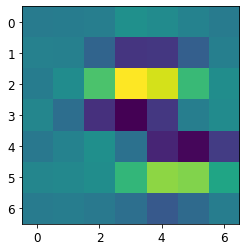

In [ ]:
plt.imshow(list(Spiral_Elliptical_Classifier.model.parameters())[0][0][0].detach())

### $\color{yellow}{\text{Useful}}$

#### **Mounting the Drive to Colab**

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


####**To delete Non Empty Files**

``` %rm -rf star ```





In [ ]:
%rm -rf drive/MyDrive/Spiral_Elliptical_Classifier/Data

#### **To Export the Images**

``` import shutil ```

```shutil.make_archive('test', 'zip', '.')```




In [ ]:
import shutil

In [ ]:
shutil.make_archive('.', 'zip', 'test')

'/content.zip'

#### **Getting the Parameters in each and every layer**

In [ ]:
#Returns Parameters(Weights) in each and every layer even through ReLU and BatchNorm too
list(Spiral_Elliptical_Classifier.model.parameters())[0].shape

torch.Size([64, 3, 7, 7])

#### **Action of Each Layers on the Tensor Stacks (Images)**

In [ ]:
#Returns Output from each and every layer even through ReLU and BatchNorm too
flatten_model(Spiral_Elliptical_Classifier.model)[90]

In [ ]:
#Requires 4 dim stacks of image tensor with same channel [-,3,-,-] and returns us the Output 
output=flatten_model(Spiral_Elliptical_Classifier.model)[0](imgs)

In [ ]:
output.shape

torch.Size([8, 64, 64, 64])